## Making bias images to analyze why parallel structure occurs in R02, R22 Differential Ratio flats

In [1]:
from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd
import lsst.eotest.sensor as sensorTest
import lsst.eotest.image_utils as imutils
from camera_components import camera_info


import glob
import os
from lsst import afw
#print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift

import math
from scipy.ndimage import gaussian_filter

from mytool import plotonesensor_ITL, plotonesensor_ITL_smooth, create_combined_ITL, plotfullraft, plotonesensor_ITL_andsave, internaladjustment
import numpy as np
import numpy

import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-4-gde602ef96+5


In [2]:
# RTM-024 : R22
# RTM-013 : R02
# look at Run 6806D as a start 

bias_files = []

slot_names = ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22']
raft = 'R02'
run = '6806D'

# adding bias files to a list
for slot in slot_names:
    bias_file = '/home/lpayne22/WORK/ITL_flats/{}-{}-{}_superbias_normal.fits'.format(raft,run,slot)
    bias_files.append(bias_file)
 
for i in range(len(bias_files)):
    print(slot_names[i])
    # Create a superbias image to use with MaskedCCD
    bias_frame = '/home/lpayne22/WORK/ITL_flats/{}-{}-{}_superbias_normal.fits'.format(raft,run,slot_names[i])
    amp_geom = sensorTest.makeAmplifierGeometry(bias_files[i])
    superbias_file = imutils.superbias_file(bias_files, amp_geom.serial_overscan, bias_frame)  #buggy - always S00 here

S00
S01
S02
S10
S11
S12
S20
S21
S22


In [83]:
def plotonesensor_ITL(img_list, title):
    fig=plt.figure(figsize=(5, 5), dpi=150)   
    columns = 8
    rows = 2
    
    image_com = None
    wholepixels = numpy.array(img_list).flatten()
    mean = numpy.mean(wholepixels,dtype=numpy.float64)
    std = mad_std(wholepixels)
    ax = []
    image_com = []  # empty list to store data for COMBINED image
    for i in range(num_ch):
        if i < columns:
            image_com.append(np.flipud(img_list[columns - (i + 1)]))    # top row must be reversed (so 07 ... 00 NOT 00 ... 07)
        else:
            image_com.append(img_list[i])                                # bootom row in normal order (08 ... 15)
    
    N = 0.5
    for i in range(0,16):
        ax1 = fig.add_subplot(rows, columns, i + 1)
        ax.append(ax1)
        ax1.set_xticks([])   
        ax1.set_yticks([])
        #im = plt.imshow(image_com[i], vmin=mean-N*std, vmax=mean+N*std, origin="lower")
        im = plt.imshow(image_com[i], vmin=0, vmax=60, origin="lower")
    plt.suptitle(title)
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
    cbar.ax.tick_params(labelsize=8)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    
# plotting one ITL sensor and saving the figure as an image for displaying full raft
def plotonesensor_ITL_andsave(diff_arr, sensor_label, raft, i):
    fig=plt.figure(figsize=(5, 5), dpi=150)   
    columns = 8
    rows = 2
    image_com = None
    wholepixels = numpy.array(diff_arr).flatten()
    mean = numpy.mean(wholepixels,dtype=numpy.float64)
    std = numpy.std(wholepixels,dtype=numpy.float64)
    ax = []
    image_com = []
    for j in range(num_ch):
        if j < columns:
            image_com.append(np.flipud(diff_arr[columns - (j + 1)]))    # top row must be reversed (so 07 ... 00 NOT 00 ... 07)
        else:
            image_com.append(diff_arr[j])                               # bootom row in normal order (08 ... 15)

    N = 0.5
    
    for k in range(0,16):
        ax1 = fig.add_subplot(rows, columns, k + 1)
        ax.append(ax1)
        ax1.set_xticks([])   
        ax1.set_yticks([])
        #im = plt.imshow(image_com[k], vmin=mean-N*std,vmax=mean+N*std,origin="lower")
        im = plt.imshow(image_com[i], vmin=0, vmax=65, origin="lower")
        
    plt.suptitle(str(sensor_label[i]))
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
    cbar.ax.tick_params(labelsize=8)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(str(raft) + "_" + str(sensor_label[i]) + "_superbias.png")
    
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    
def plotfullraft(title, ratio_img_list):
    num_ch = 16
    num_CCDs = 9
    fig, axs = plt.subplots(3, 3, figsize=(20, 20),dpi=300) 
    axs = axs.ravel()
    fig.suptitle(title, fontsize=16)
    columns = 3
    rows = 3
    ax = []
    for i in range(num_CCDs):
        ax1 = fig.add_subplot(rows, columns, i + 1)
        ax1.axis('off')    # gets rid of subplot borders
        img=mpimg.imread(str(ratio_img_list[i]))
        plt.imshow(img)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])  # gets rid of ALL ticks
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

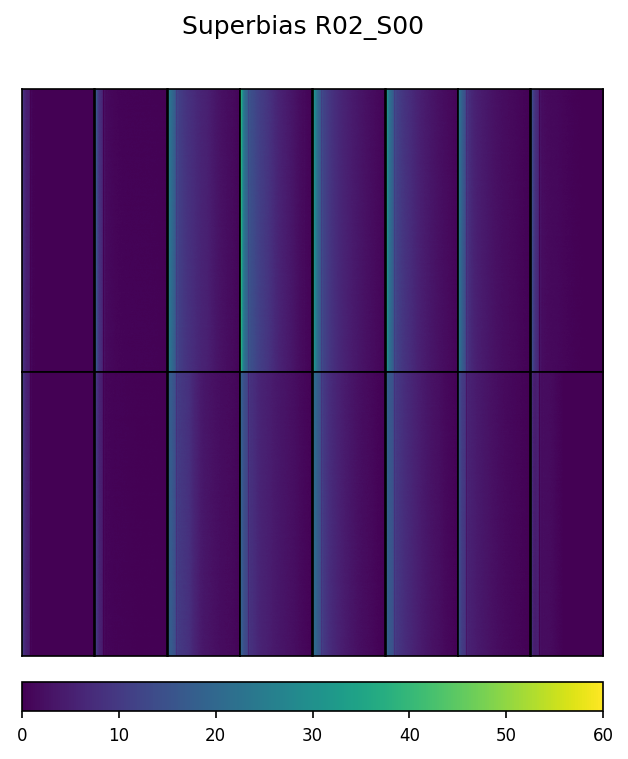

In [84]:
# plot bias for S00 
num_ch = 16
superbias_arr = [None] * num_ch
superbias = get_ccd_from_id(None, bias_files[0], [])     # load superbias

for ch in range(num_ch):    
    superbias_data = get_data_as_read(superbias,ch + 1,["imaging"])["imaging"]    # QE data array for CCOB bias flat field image
    superbias_arr[ch] = superbias_data                                          # adding data at this amp to data array


# display bias flat image
plotonesensor_ITL(superbias_arr, 'Superbias ' + str(raft) + '_' + str(slot_names[0]))
print()

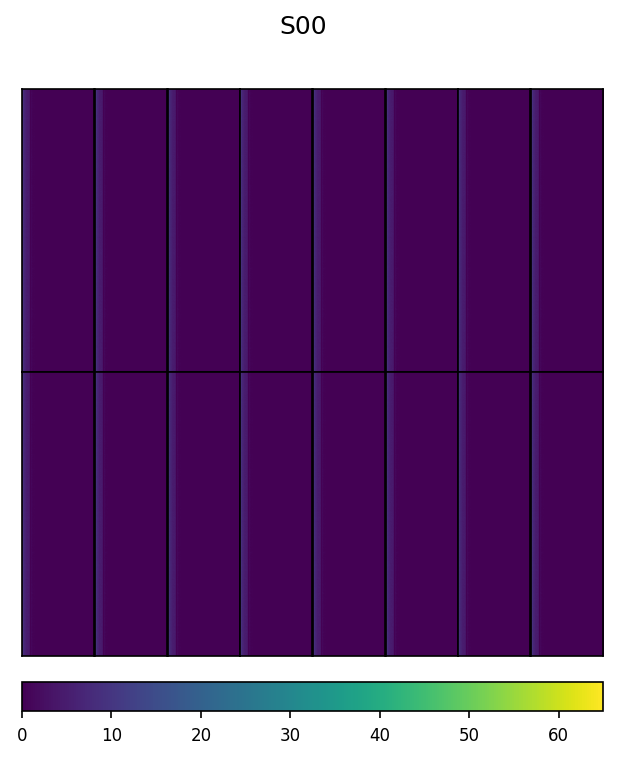

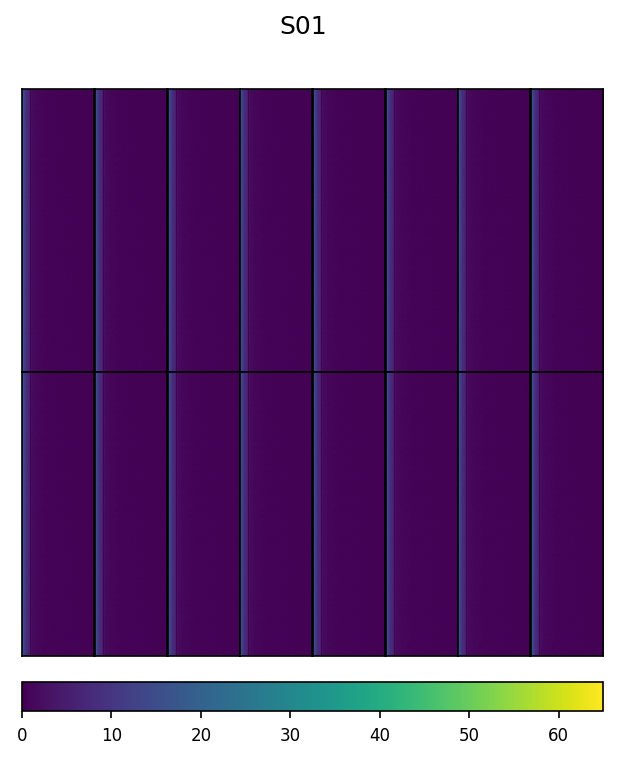

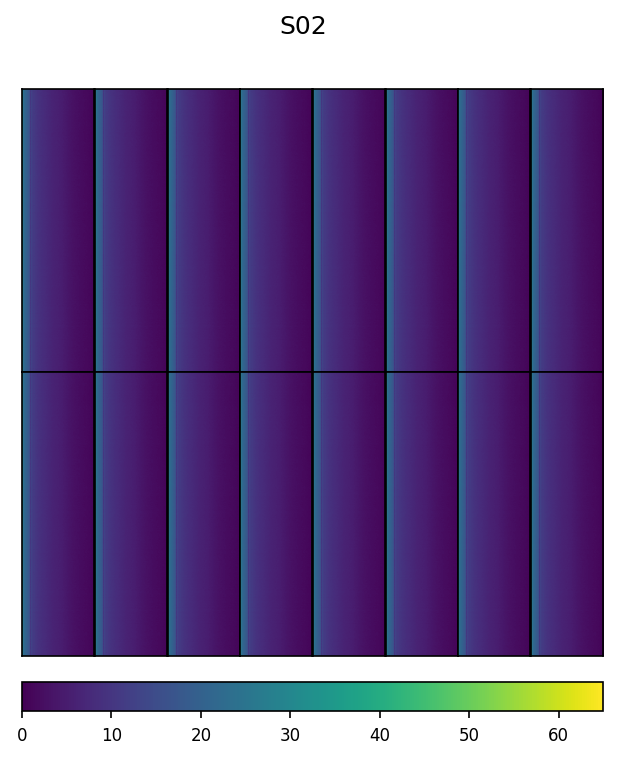

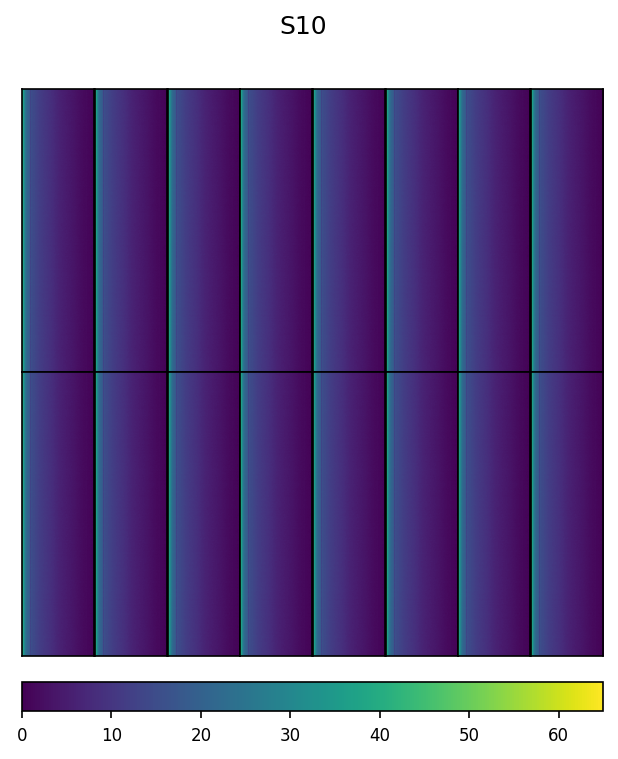

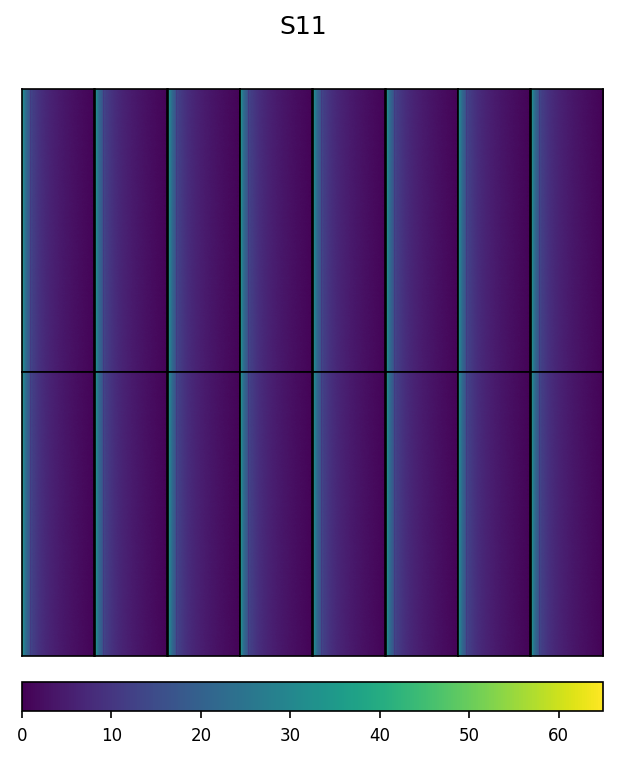

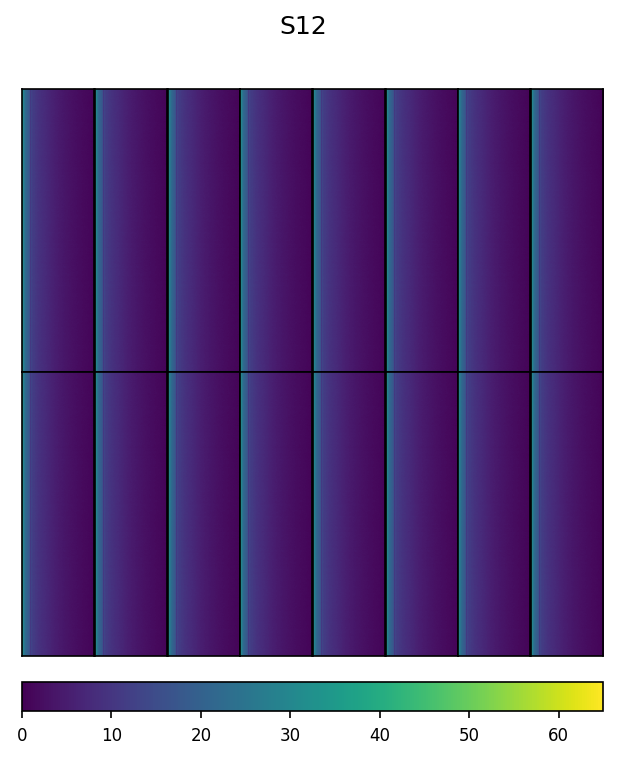

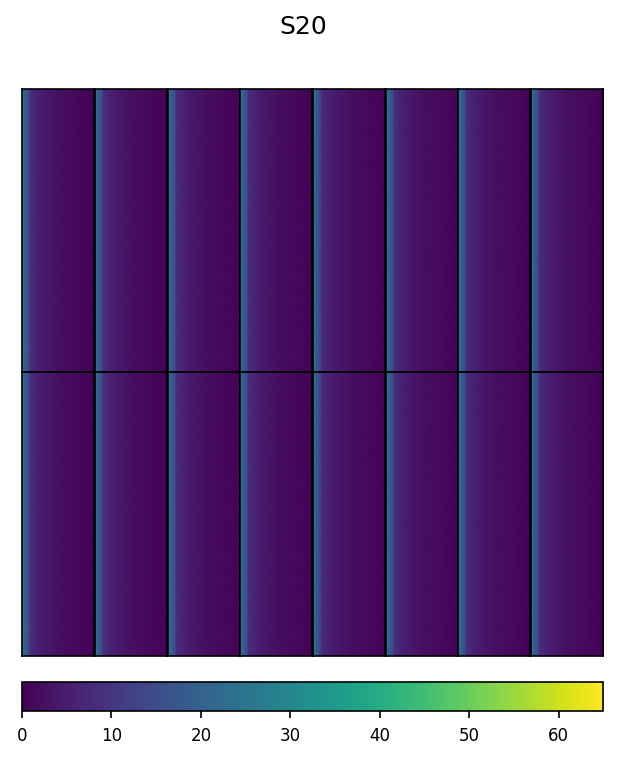

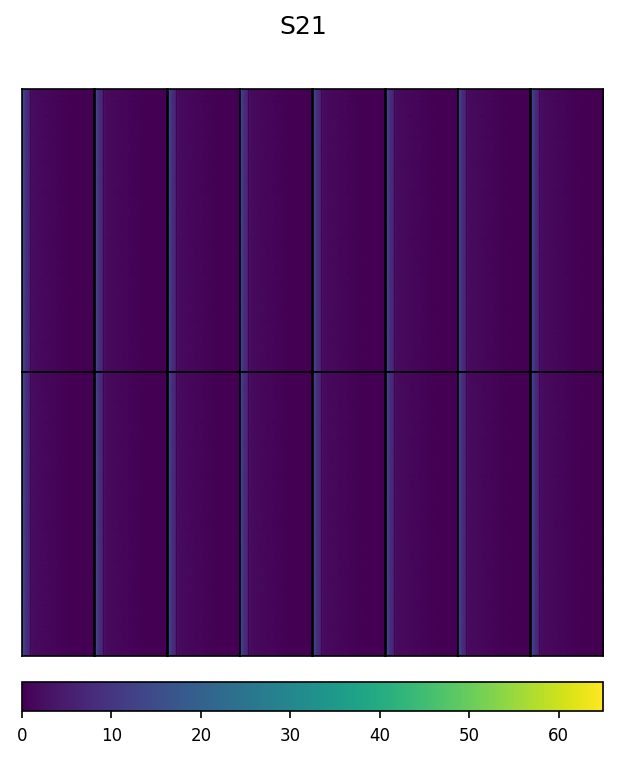

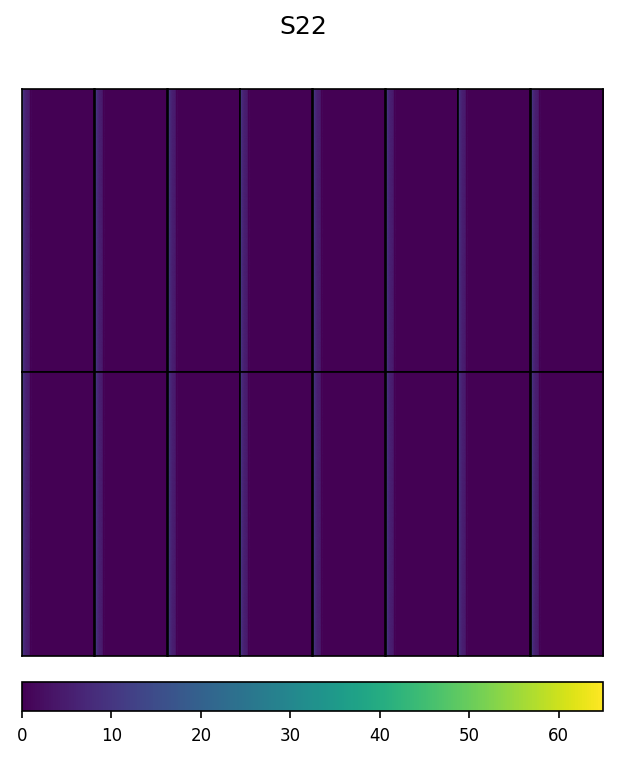

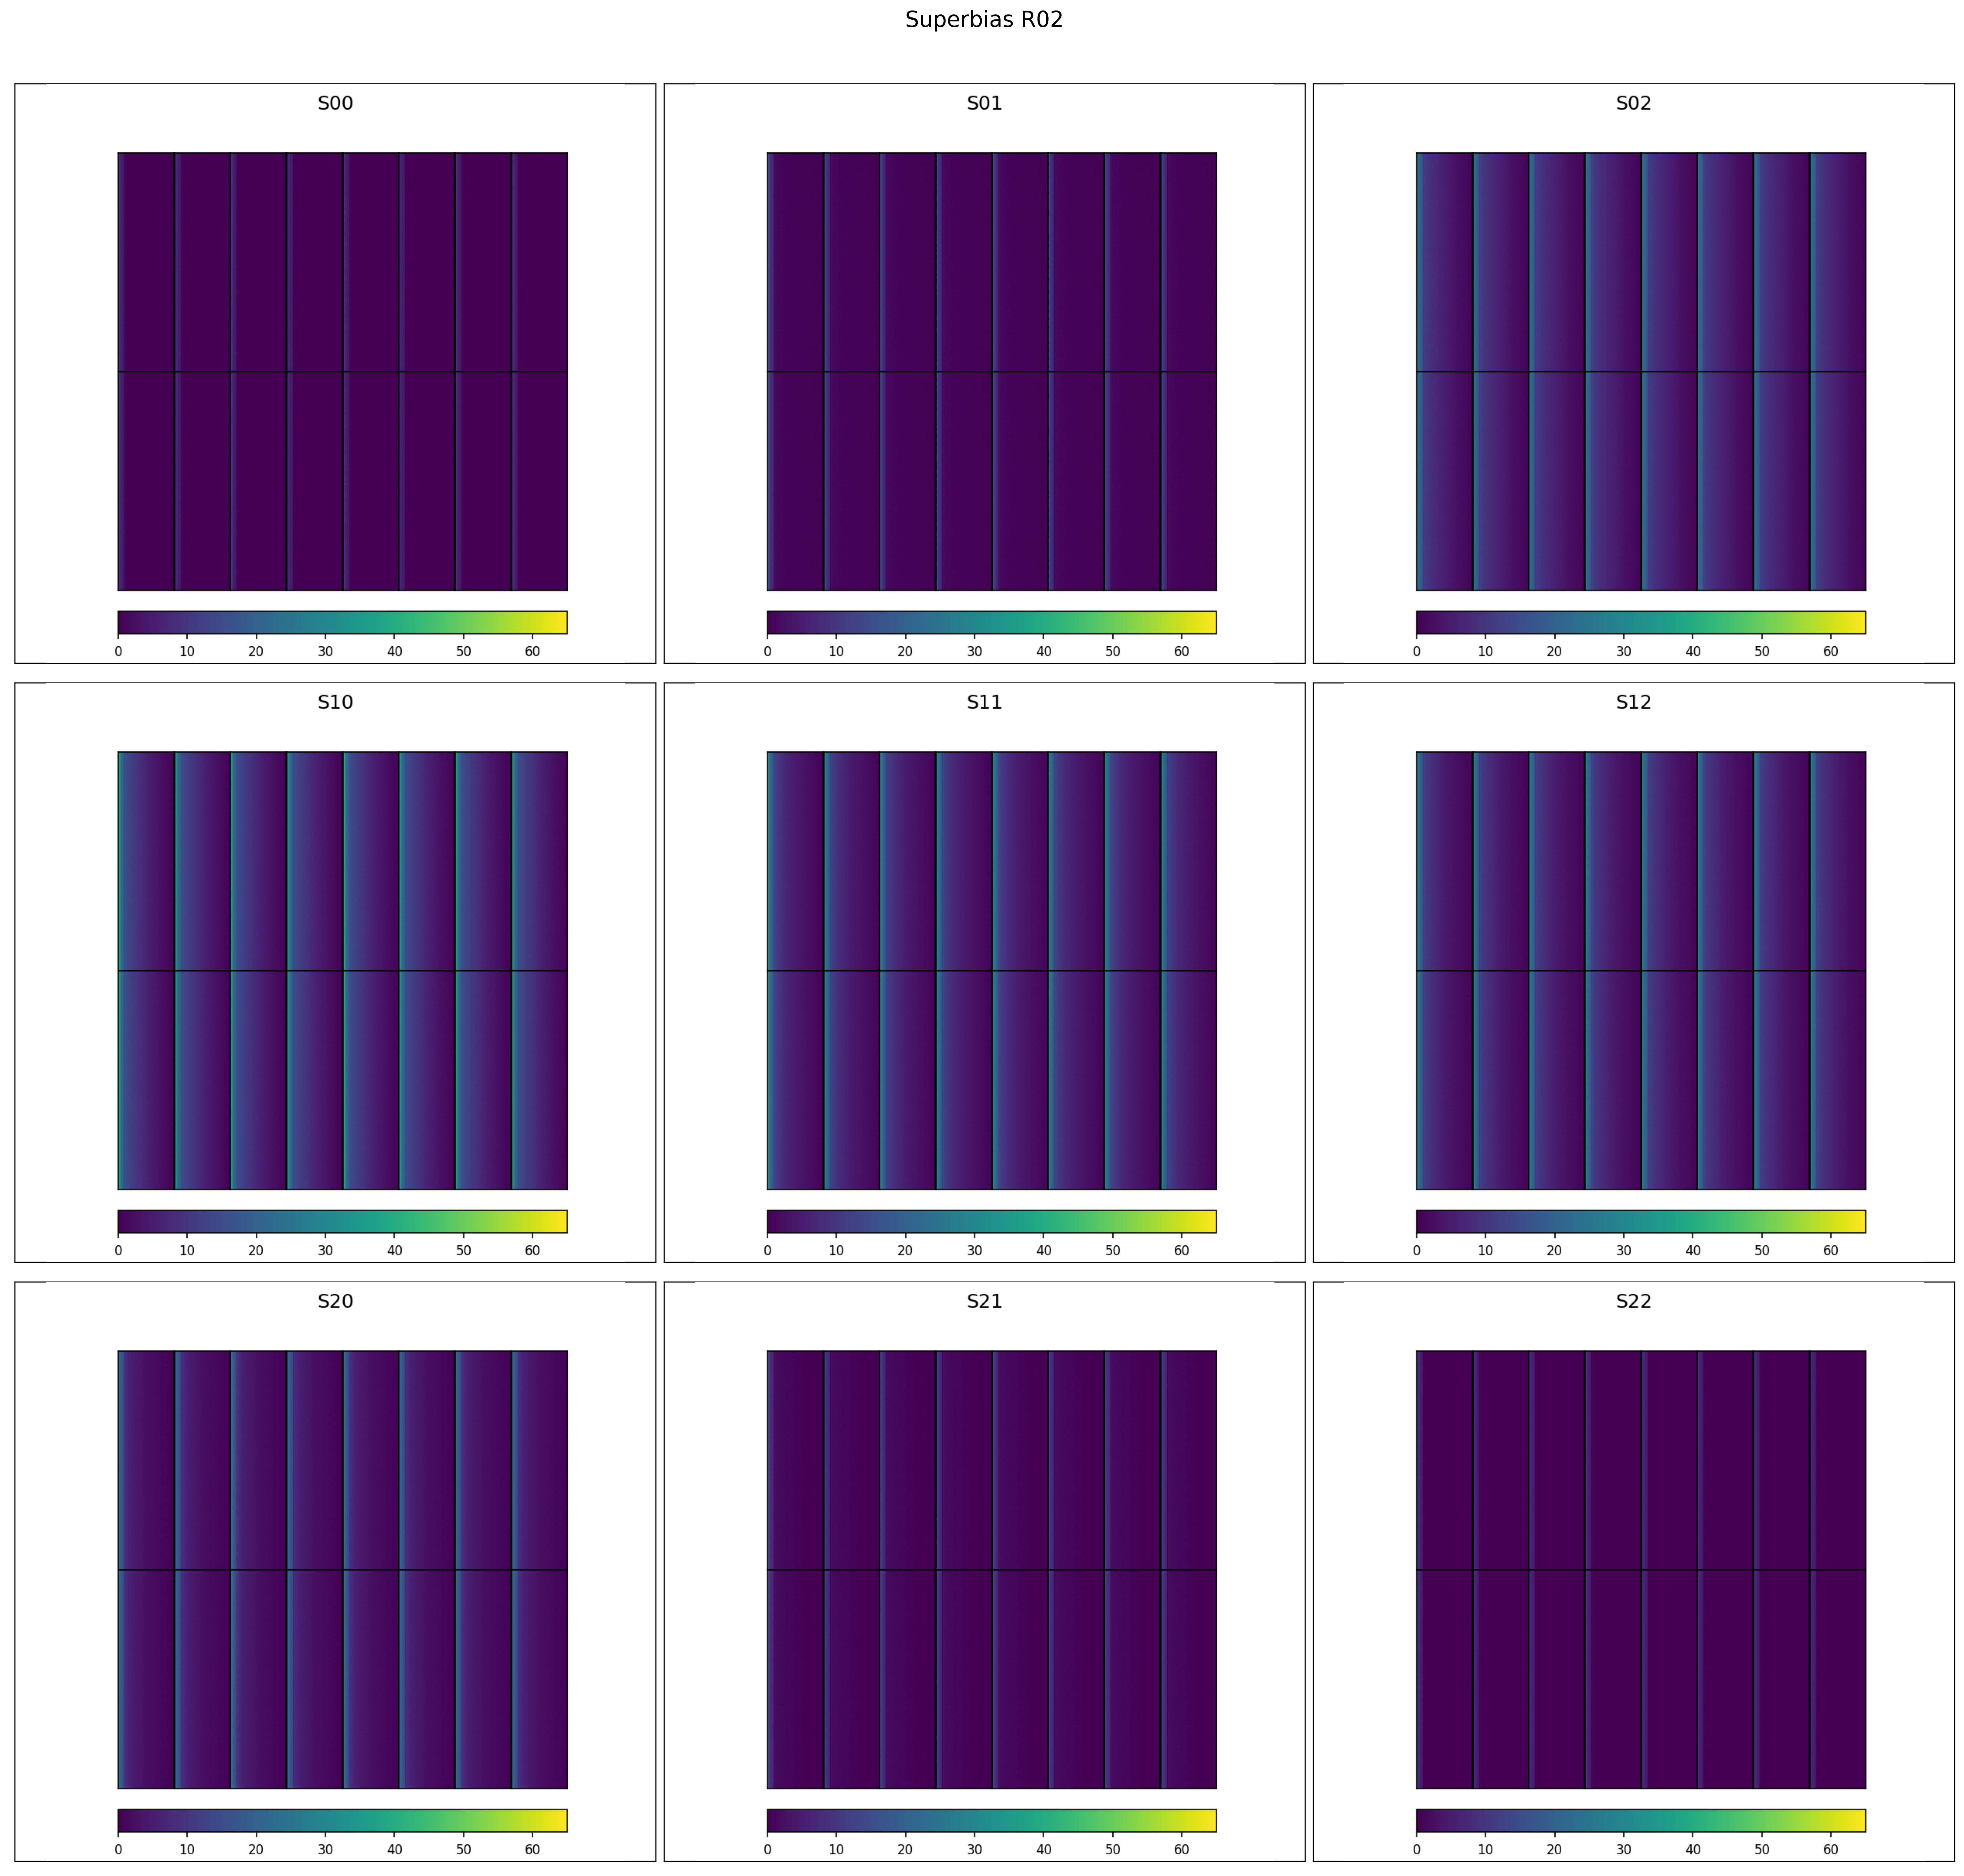

In [85]:
# RTM-024 : R22
# RTM-013 : R02
# look at Run 6806D as a start 

num_ch = 16
num_CCDs = 9
superbias_arr = [None] * num_ch

for i in range(num_CCDs):
    superbias = get_ccd_from_id(None, bias_files[0], [])     # load superbias
    for ch in range(num_ch):    
        superbias_data = get_data_as_read(superbias,ch + 1,["imaging"])["imaging"]    # QE data array for CCOB bias flat field image
        superbias_arr[ch] = superbias_data                                          # adding data at this amp to data array
    # display bias flat image
    plotonesensor_ITL_andsave(superbias_arr, slot_names, raft, i)


superbias_img_list = ['R02_S00_superbias.png', 'R02_S01_superbias.png', 'R02_S02_superbias.png', 'R02_S10_superbias.png', 'R02_S11_superbias.png', 'R02_S12_superbias.png', 'R02_S20_superbias.png', 'R02_S21_superbias.png', 'R02_S22_superbias.png']
title = 'Superbias ' + str(raft)

plotfullraft(title, superbias_img_list)